# Carnet Jupyter associé à l'article

Ce Carnet vise à montrer comment les figures de l'article https://www.mdpi.com/1660-4601/18/5/2611 ont été produites. Il n'est pas complet, et le recodage des variables a pu évoluer depuis le traitement de l'article.

**version du 25/11/2021**

## Chargement des bibliothèques

In [1]:
# Chargement des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import pyshs
import numpy as np, scipy.stats as st
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pyshs
%matplotlib inline

## Chargement des données et recodage

### Chargement

In [37]:
# Chargement des données
data = pd.read_excel("HLS19 Vague2/bdd2.xlsx")
data = data[data["Vague"] == 1] # sélection de la vague 1

### Recodage

Recodage des variables au cours de l'analyse

In [82]:
data["zones"] = data["FRINSEEMKTSIZE"].replace({1:"Rural",2:"Urban <20k",3:"Urban <100k",4:"Urban >100k",5:"Paris"})
data["sexe"] = data["resp_gender"]
data["age"] = pd.cut(data["resp_age"],[0,25,45,65,100],labels = ["[0-25[","[25-45[","[45-65[","[65+"])
data["age2"] = pd.cut(data["resp_age"],[0,35,45,55,65,100],
                labels = ["[18-35[","[35-45[","[45-55[","[55-65[","[65-75]"])
def reco(x):
    if x<4:
        return "1 - Below BD"
    if x == 4:
        return "2 - BD"
    else:
        return "3 - Above BD"
data["dip"] = data["DET6"].apply(reco)

data["rechercheinfo"] = data["HI1"].replace({1:"1 - Yes",2:"2 - No"})
data["DET8"] = data["DET8"].replace({1:"Yes",2:"No"})
data["rev"] = data["D16"].replace({1:"1 - less than 1000",2:"1 - less than 1000",3:"1 - less than 1000",
                     4:"2 - 1000 to 2000",5:"2 - 1000 to 2000",6:"2 - 1000 to 2000",
                     7:"3 - 2000 to 3000",8:"3 - 2000 to 3000",9:"4 - 3000 to 5000",
                     10:"5 - 5000 and more",11:"5 - 5000 and more",12:"6 - NSPR"
                    
                    })

data["rev2"] = data["D16"].replace({1:"1 - less than 1000",2:"1 - less than 1000",3:"1 - less than 1000",
                     4:"2 - 1000 to 2000",5:"2 - 1000 to 2000",6:"2 - 1000 to 2000",
                     7:"3 - 2000 to 3000",8:"3 - 2000 to 3000",9:"4 - 3000 and more",
                     10:"4 - 3000 and more",11:"4 - 3000 and more",12:"5 - NSPR"
                    })
data["EtatSante"] = data["HSTAT1"].replace({1:"1 - Good",2:"1 - Good",3:"2 - Average",4:"3 - Bad",5:"3 - Bad"})

data["confIndustriels"] = data['CONF_6._scale'].replace({1:"1 - Yes",2:"1 - Yes",3:"2 - No",4:"2 - No"})
data["confMedecins"] = data['CONF_4._scale'].replace({1:"1 - Yes",2:"1 - Yes",3:"2 - No",4:"2 - No"})
data["confScientifiques"] = data['CONF_3._scale'].replace({1:"1 - Yes",2:"1 - Yes",3:"2 - No",4:"2 - No"})
data["confPolitiques"] = data['CONF_2._scale'].replace({1:"1 - Yes",2:"1 - Yes",3:"2 - No",4:"2 - No"})

data["PERCEPTCORONA"] = data["COV3"].replace({1:"1 - Yes",2:"2 - Some",3:"2 - Some",4:"3 - No"})

# Indicateur de défavorisation économique
data["def"] = data.apply(lambda x : "Yes" if (x["DET10"]>2) or (x["DET11"]>2) else "No",axis=1)
data["DEF"] = data["def"]


# Indicateur de littéracie sur 16 items (HL, Rouquette et al.)
def reco(x):
    if pd.isnull(x):
        return None
    if x in [1,2]:
        return 1
    return 0
c = ["HL1_"+str(i)+"._scale" for i in range(1,9) if not i in [4,6]] + \
    ["HL2_"+str(i)+"._scale" for i in range(1,8) if i!=5]+ \
    ["HL3_"+str(i)+"._scale" for i in range(1,8) if not i in [1,5,7]]
for i in c :
    data[i+"_reco"] = data[i].apply(reco)
    
data["lit_num"] = data[[i+"_reco" for i in c]].sum(axis=1)

# Découpage en catégories
def reco(x):
    if pd.isnull(x):
        return None
    if x<9:
        return "3 - Inadequate"
    if x<13:
        return "2 - Problematic"
    else:
        return "1 - Adequate"
data["lit_scale"] = data["lit_num"].apply(reco)


# Connaissance des essais
data["ConnaissanceEC"] = data["EC0"].replace({3:"3-Somewhat familiar with what CTs are", 5:"5-Extremely familiar with what CTs are", 
        2:"2-Only know the term, CTs", 4:"4-Very familiar with what CTs are", 1:"1-Never heard of CTs before today"})
data["ConnaissanceECT"] = data["EC0"].replace({3:"2-Somewhat familiar", 5:"1-Familiar", 
        2:"3-Not familiar", 4:"1-Familiar", 1:"3-Not familiar"})
data["ConnaissanceBien"] = data["ConnaissanceEC"].apply(lambda x : 1 if x 
                    in ["5-Extremely familiar with what CTs are","4-Very familiar with what CTs are"] else 0)
data["familiarityCT"] = data["ConnaissanceBien"].replace({0:"1-No",1:"2-Yes"})
data["Phase"] = data["EC3"].replace({1:"Yes",2:"No"}).fillna("NA")
data["avisEC_score"] = data["EC2__1._scale"]
data["avisEC_C"] = pd.qcut(data["EC2__1._scale"],[0,0.33,0.66,1],["Q1","Q2","Q3"])
data["FavorableEC"] = data["avisEC_score"].apply(lambda x : 1 if x >=6 else 0) 

# Autres variables
data["collaboreIndustriels"] = data['RM_4._scale'].replace({1:"Agree",2:"Agree",3:"Disagree",4:"Disagree"}).fillna("NA")
data["chomagePlusImportant"] = data['RM_5._scale'].replace({1:"Agree",2:"Agree",3:"Disagree",4:"Disagree"}).fillna("NA")
data["avisCitoyens"] = data['RM_7._scale'].replace({1:"Agree",2:"Agree",3:"Disagree",4:"Disagree"}).fillna("NA")
data["prioriteNouvellesMaladies"] = data['RM_8._scale'].replace({1:"Agree",2:"Agree",3:"Disagree",4:"Disagree"}).fillna("NA")

for i in [i for i in data.columns if "RM_" in i]:
    data[i] = data[i].replace({1:"1 - Agree",2:"2 - Rather agree",3:"3 - Rather disagree",4:"4 - Disagree"}).fillna("NA")


## Quelques explorations

Avis sur la recherche clinique

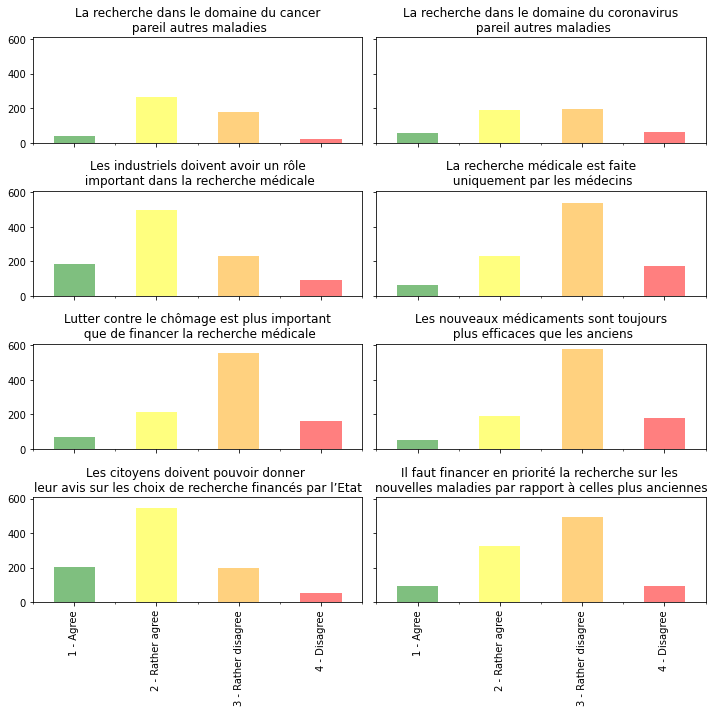

In [45]:
s = [i for i in data.columns if "RM" in i]

title = ["La recherche dans le domaine du cancer\n pareil autres maladies",
"La recherche dans le domaine du coronavirus\n pareil autres maladies",
"Les industriels doivent avoir un rôle\n important dans la recherche médicale",
"La recherche médicale est faite\n uniquement par les médecins",
"Lutter contre le chômage est plus important\n que de financer la recherche médicale",
"Les nouveaux médicaments sont toujours\n plus efficaces que les anciens",
"Les citoyens doivent pouvoir donner \nleur avis sur les choix de recherche financés par l’Etat",
"Il faut financer en priorité la recherche sur les \nnouvelles maladies par rapport à celles plus anciennes"]

fig,ax = plt.subplots(4,2,figsize=(10,10),sharex=True,sharey=True)
ax = ax.flatten()

for i in range(0,len(s)-1):
    t = pyshs.tri_a_plat(data,s[i],"weight")["Effectif redressé"].sort_index().drop("Total")
    t.plot(kind="bar",ax=ax[i],color=["green","yellow","orange","red"],alpha=0.5)
    ax[i].set_title(title[i])
    
plt.tight_layout()
#plt.savefig("RM-triaplat.png",dpi=200)

Connaissance des essais cliniques

In [55]:
t = pyshs.tri_a_plat(data,"ConnaissanceEC","weight").drop("Total")
t

,Effectif redressé,Pourcentage (%)
1-Never heard of CTs before today,37.6,3.7
"2-Only know the term, CTs",315.1,31.4
3-Somewhat familiar with what CTs are,454.6,45.3
4-Very familiar with what CTs are,149.2,14.9
5-Extremely familiar with what CTs are,46.5,4.6


<AxesSubplot:>

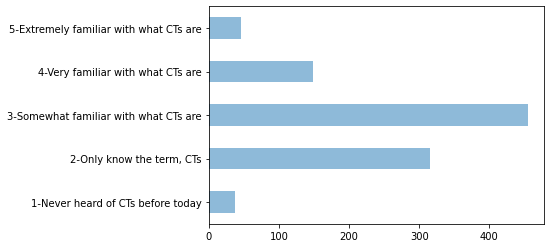

In [53]:
t["Effectif redressé"].plot(kind="barh",alpha=0.5)

Connaissance de la division en phase

In [57]:
pyshs.tri_a_plat(data,"Phase","weight").drop("Total")

,Effectif redressé,Pourcentage (%)
NA,37.6,3.7
No,479.4,47.8
Yes,486.0,48.5


D’après ce que vous en savez, quelle est votre impression générale sur les essais cliniques ?


<AxesSubplot:>

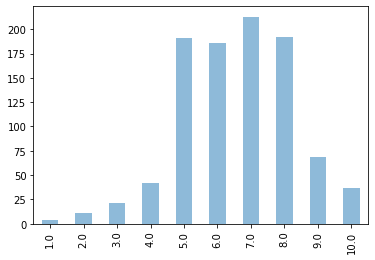

In [61]:
data["avisEC_score"].value_counts().sort_index().plot(kind="bar",alpha=0.5)

In [62]:
data["avisEC_score"].describe()

count    966.000000
mean       6.569358
std        1.674203
min        1.000000
25%        5.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: avisEC_score, dtype: float64

Avis sur les essais

/Users/emilien/anaconda3/envs/p37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


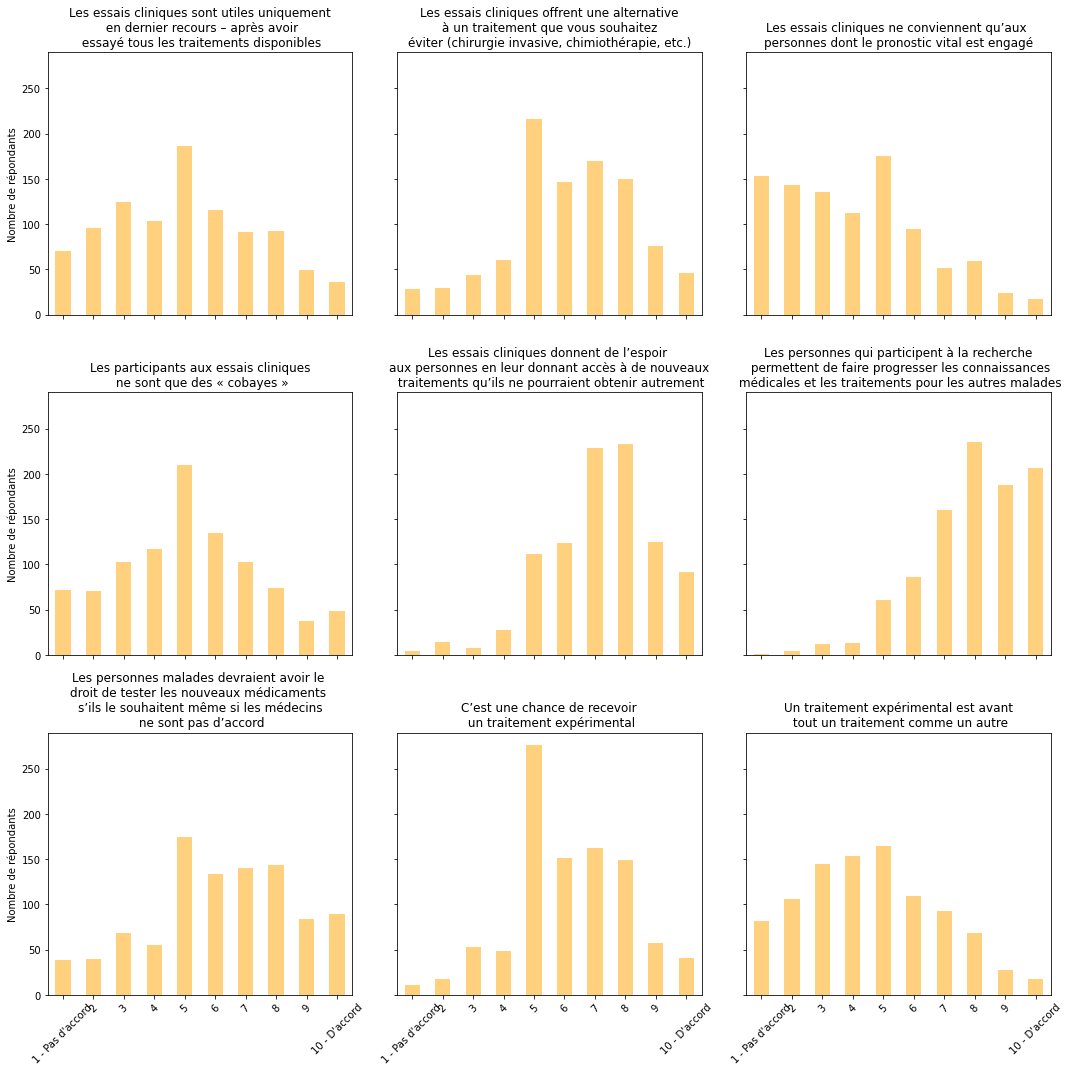

In [65]:
s = ["EC4__"+str(i)+"._scale" for i in range(1,10)]
fig,ax = plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)
titles = [
    "Les essais cliniques sont utiles uniquement\n en dernier recours – après avoir\n essayé tous les traitements disponibles",
    "Les essais cliniques offrent une alternative\n à un traitement que vous souhaitez \néviter (chirurgie invasive, chimiothérapie, etc.)",
    "Les essais cliniques ne conviennent qu’aux \npersonnes dont le pronostic vital est engagé",
    "Les participants aux essais cliniques\n ne sont que des « cobayes »",
    "Les essais cliniques donnent de l’espoir \naux personnes en leur donnant accès à de nouveaux\n traitements qu’ils ne pourraient obtenir autrement",
    "Les personnes qui participent à la recherche\n permettent de faire progresser les connaissances\n médicales et les traitements pour les autres malades",
    "Les personnes malades devraient avoir le \ndroit de tester les nouveaux médicaments \ns’ils le souhaitent même si les médecins\n ne sont pas d’accord",
    "C’est une chance de recevoir\n un traitement expérimental",
    "Un traitement expérimental est avant\n tout un traitement comme un autre"]
ax = ax.flatten()
for i in range(0,len(s)):
    t =data[s[i]].value_counts().sort_index()
    t.index = ["1 - Pas d'accord","2","3","4","5","6","7","8","9","10 - D'accord"]
    t.plot(kind="bar",ax=ax[i],color="orange",alpha=0.5,rot=45)
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Nombre de répondants")
#plt.suptitle("Affirmations à propos des essais cliniques\n (en nombre de répondants)")
plt.tight_layout()
#plt.savefig("AFFIRMATIONS-triaplat.png",dpi=200)
 

Résumé

In [73]:
s = ["EC4__"+str(i)+"._scale" for i in range(1,10)]
titles = [
    "Utiles uniquement en dernier recours",
    "Alternative à un traitement que vous souhaitez éviter",
    "Que pour les personnes dont le pronostic vital est engagé",
    "Les participants ne sont que des « cobayes »",
    "Donnent de l’espoir aux personnes en donnant accès à de nouveaux traitements",
    "Les personnes qui participent à la recherche permettent de faire progresser les connaissances médicales",
    "Les personnes malades devraient avoir le droit de tester les nouveaux médicaments",
    "C’est une chance de recevoir un traitement expérimental",
    "Un traitement expérimental est avant tout un traitement comme un autre"]

df = pd.DataFrame(round(data[s].mean(),2))
df["std"] = round(data[s].std(),2)
df["ic"] = data[s].apply(lambda x : st.t.interval(0.95, len(x.dropna())-1, 
                                    loc=np.mean(x.dropna()), scale=st.sem(x.dropna())))

df["ic"] = df["ic"].apply(lambda x : "[{}-{}]".format(round(x[0],2),round(x[1],2)))
df.index = titles
df.columns = ["Moyenne","Ecart-type","Intervalle"]
df

,Moyenne,Ecart-type,Intervalle
Utiles uniquement en dernier recours,5.03,2.41,[4.88-5.18]
Alternative à un traitement que vous souhaitez éviter,6.16,2.08,[6.03-6.29]
Que pour les personnes dont le pronostic vital est engagé,4.10,2.33,[3.95-4.25]
Les participants ne sont que des « cobayes »,5.13,2.34,[4.99-5.28]
Donnent de l’espoir aux personnes en donnant accès à de nouveaux traitements,7.22,1.74,[7.11-7.33]
Les personnes qui participent à la recherche permettent de faire progresser les connaissances médicales,7.94,1.69,[7.83-8.05]
Les personnes malades devraient avoir le droit de tester les nouveaux médicaments,6.20,2.38,[6.05-6.35]
C’est une chance de recevoir un traitement expérimental,6.14,1.88,[6.03-6.26]
Un traitement expérimental est avant tout un traitement comme un autre,4.59,2.23,[4.45-4.73]


Confiance

/Users/emilien/anaconda3/envs/p37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


Text(0.5, 0.98, 'Enquête Canbios/SESSTIM : Confiance dans ...\n (en nombre de répondants)')

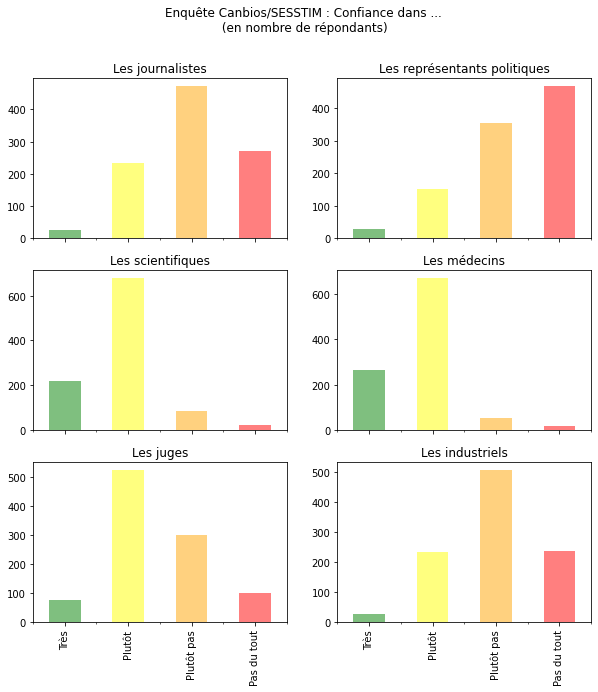

In [67]:
s = ["CONF_"+str(i)+"._scale" for i in range(1,7)]
fig,ax = plt.subplots(3,2,figsize=(10,10),sharex=True)
ax = ax.flatten()
title = ["Les journalistes","Les représentants politiques","Les scientifiques",
         "Les médecins","Les juges","Les industriels"]
for i in range(0,len(s)):
    t =data[s[i]].value_counts().sort_index()
    t.index = ["Très","Plutôt","Plutôt pas","Pas du tout"]
    t.plot(kind="bar",ax=ax[i],color=["green","yellow","orange","red"],alpha=0.5)
    ax[i].set_title(title[i])
plt.suptitle("Enquête Canbios/SESSTIM : Confiance dans ...\n (en nombre de répondants)")
# plt.savefig("CONF-triaplat.png",dpi=200)

## Figures de l'article

### Tableau 1

In [71]:
d = pd.concat({'Sex': pyshs.tri_a_plat(data,"sexe","weight"),
               'Age': pyshs.tri_a_plat(data,"age","weight"),
               'Education': pyshs.tri_a_plat(data,"dip","weight"),
               'Financial difficulties': pyshs.tri_a_plat(data,"def","weight"),
               'Health condition': pyshs.tri_a_plat(data,"EtatSante","weight"),
               'Information search': pyshs.tri_a_plat(data,"rechercheinfo","weight"),
               'Concerns about COVID19': pyshs.tri_a_plat(data,"PERCEPTCORONA","weight"),
               'Health literacy': pyshs.tri_a_plat(data,"lit_scale","weight")

              }, 
              names=['Factors'])
# d.to_excel("./Figures/Table1.xls")
d


Effectif redressé  Pourcentage (%)
Factors                                                                   
Sex                    female                       515.5             51.4
                       male                         487.5             48.6
                       Total                       1003.0            100.0
Age                    [0-25[                       130.4             13.0
                       [25-45[                      366.1             36.5
                       [45-65[                      378.1             37.7
                       [65+                         128.4             12.8
                       Total                       1003.0            100.0
Education              1 - Below BD                 169.8             16.9
                       2 - BD                       240.1             23.9
                       3 - Above BD                 593.1             59.1
                       Total                       1003.0             99.9
Financial difficulties No                           643.0             64.1
                       Yes                          360.0             35.9
                       Total                       1003.0            100.0
Health condition       1 - Good                     649.2             64.7
                       2 - Average                  281.3             28.0
                       3 - Bad                       72.5              7.2
                       Total                       1003.0             99.9
Information search     1 - Yes                      866.9             86.4
                       2 - No                       136.1             13.6
                       Total                       1003.0            100.0
Concerns about COVID19 1 - Yes                      264.9             26.4
                       2 - Some                     683.6             68.2
                       3 - No                        54.5              5.4
                       Total                       1003.0            100.0
Health literacy        1 - Adequate                 604.8             60.3
                       2 - Problematic              263.6             26.3
                       3 - Inadequate               134.6             13.4
                       Total                       1003.0            100.0

## Figure 1

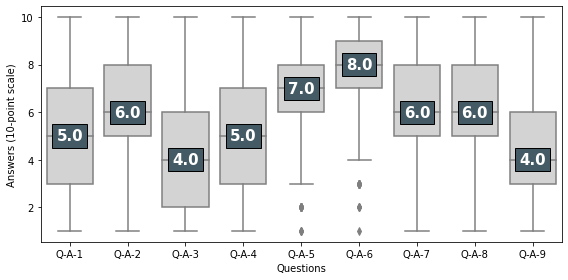

In [74]:
s = ["EC4__"+str(i)+"._scale" for i in range(1,10)]
t = data[s]
t.columns = ["Q-A-%d"%i for i in range(1,10)]

fix,ax = plt.subplots(figsize=(8,4))
box_plot = sns.boxplot(data=t,color="lightgray")

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1) 
    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=15,
        color='white',
        bbox=dict(facecolor='#445A64'))
plt.xlabel("Questions")
plt.ylabel("Answers (10-point scale)")
box_plot.figure.tight_layout()
#plt.savefig("./Figures/Fig2.png",dpi=200)

## Table 2

In [111]:
var_ind = {"sexe":"1 - Sex",
            "dip":"2 - Education",
            "DEF":"3 - Economic deprivation",
            "lit_scale":"4 - HLS",
            "rechercheinfo":"5 - Health Information",
            "confScientifiques":"6 - Trust in scientifics",
            "confMedecins":"7 - Trust in doctors",
            "confPolitiques":"8 - Trust in politicans",
            "confIndustriels":"9 - Trust in companies"}

m1 = pyshs.regression_logistique(data,"ConnaissanceBien",var_ind,"weight")

var_ind["familiarityCT"] = "CT Familiarity"
data2 = data[data["ConnaissanceEC"]!='1-Never heard of CTs before today']
m2 = pyshs.regression_logistique(data2,"FavorableEC",var_ind,"weight")

pd.concat({"Familiarity":m1,"Attitude":m2},axis=1)

Familiarity           \
                                          Odds Ratio        p   
Variable                 Modalité                               
.Intercept                                      0.24   0.0***   
1 - Sex                  female                  ref            
                         male                   1.15    0.401   
2 - Education            1 - Below BD            ref            
                         2 - BD                 1.33    0.329   
                         3 - Above BD           1.94  0.009**   
3 - Economic deprivation No                      ref            
                         Yes                       1    0.995   
4 - HLS                  1 - Adequate            ref            
                         2 - Problematic        0.55  0.003**   
                         3 - Inadequate         0.57   0.047*   
5 - Health Information   1 - Yes                 ref            
                         2 - No                 0.34  0.001**   
6 - Trust in scientifics 1 - Yes                 ref            
                         2 - No                 0.75    0.397   
7 - Trust in doctors     1 - Yes                 ref            
                         2 - No                 1.59    0.192   
8 - Trust in politicans  1 - Yes                 ref            
                         2 - No                 1.01    0.981   
9 - Trust in companies   1 - Yes                 ref            
                         2 - No                 0.73    0.107   
CT Familiarity           1-No                    NaN      NaN   
                         2-Yes                   NaN      NaN   

                                                             Attitude  \
                                                    IC 95% Odds Ratio   
Variable                 Modalité                                       
.Intercept                                0.24 [0.13-0.45]       4.29   
1 - Sex                  female                                   ref   
                         male             1.15 [0.83-1.59]       1.32   
2 - Education            1 - Below BD                             ref   
                         2 - BD           1.33 [0.75-2.38]       1.24   
                         3 - Above BD     1.94 [1.18-3.19]       1.26   
3 - Economic deprivation No                                       ref   
                         Yes              1.00 [0.70-1.42]       0.63   
4 - HLS                  1 - Adequate                             ref   
                         2 - Problematic  0.55 [0.37-0.82]       0.71   
                         3 - Inadequate   0.57 [0.33-0.99]       0.83   
5 - Health Information   1 - Yes                                  ref   
                         2 - No           0.34 [0.18-0.65]       0.67   
6 - Trust in scientifics 1 - Yes                                  ref   
                         2 - No           0.75 [0.39-1.45]       0.68   
7 - Trust in doctors     1 - Yes                                  ref   
                         2 - No           1.59 [0.79-3.19]       0.46   
8 - Trust in politicans  1 - Yes                                  ref   
                         2 - No           1.01 [0.65-1.56]       0.51   
9 - Trust in companies   1 - Yes                                  ref   
                         2 - No           0.73 [0.49-1.07]       1.09   
CT Familiarity           1-No                          NaN        ref   
                         2-Yes                         NaN        2.6   

                                                                     
                                                p            IC 95%  
Variable                 Modalité                                    
.Intercept                                 0.0***  4.29 [2.35-7.86]  
1 - Sex                  female                                      
                         male               0.074  1.32 [0.97-1.78]  
2 - Education            1 - Be

In [124]:
var_names = {"age2":"Age","dip":"Education","sexe":"Sex","DEF":"Financial difficulties",
            "lit_scale":"Health litteracy","rechercheinfo":"HI seeking behaviour","EtatSante":"Health condition",
             "PERCEPTCORONA":"COVID19 concerns","confScientifiques":'Trust in scientists',
             "confMedecins":'Trust in doctors',"confPolitiques":'Trust in politicians',
             "confIndustriels":'Trust in the industry'}

t = pyshs.tableau_croise_multiple(data,"familiarityCT",var_names,weight="weight")[["2-Yes"]]
t.columns = ["Familiar"]
t

Familiar
Variable                           Modalités                   
Age (p = 0.756)                    [18-35[           59 (20.3%)
                                   [35-45[           34 (17.4%)
                                   [45-55[           43 (21.6%)
                                   [55-65[           38 (20.3%)
                                   [65-75]           22 (16.8%)
                                   Total            196 (19.5%)
Education (p = 0.002)              1 - Below BD      22 (12.8%)
                                   2 - BD            37 (15.5%)
                                   3 - Above BD     137 (23.1%)
                                   Total            196 (19.5%)
Sex (p = 0.392)                    female            93 (18.4%)
                                   male             103 (20.7%)
                                   Total            196 (19.5%)
Financial difficulties (p = 0.298) No               133 (20.6%)
                                   Yes               63 (17.6%)
                                   Total            196 (19.5%)
Health litteracy (p = 0.003)       1 - Adequate     139 (23.0%)
                                   2 - Problematic   38 (14.4%)
                                   3 - Inadequate    19 (14.1%)
                                   Total            196 (19.5%)
HI seeking behaviour (p = 0.000)   1 - Yes          185 (21.3%)
                                   2 - No             11 (8.1%)
                                   Total            196 (19.5%)
Health condition (p = 0.669)       1 - Good         127 (19.7%)
                                   2 - Average       52 (18.4%)
                                   3 - Bad           17 (23.0%)
                                   Total            196 (19.5%)
COVID19 concerns (p = 0.283)       1 - Yes           56 (21.1%)
                                   2 - Some         126 (18.4%)
                                   3 - No            14 (26.4%)
                                   Total            196 (19.5%)
Trust in scientists (p = 0.177)    1 - Yes          181 (20.2%)
                                   2 - No            15 (14.2%)
                                   Total            196 (19.5%)
Trust in doctors (p = 0.946)       1 - Yes          182 (19.5%)
                                   2 - No            14 (20.6%)
                                   Total            196 (19.5%)
Trust in politicians (p = 0.251)   1 - Yes           41 (22.9%)
                                   2 - No           155 (18.8%)
                                   Total            196 (19.5%)
Trust in the industry (p = 0.048)  1 - Yes           62 (23.9%)
                                   2 - No           134 (18.0%)
                                   Total            196 (19.5%)

In [129]:
t = pyshs.tableau_croise_multiple(data,"FavorableEC",var_names,weight="weight")[[1]]
t.columns = ["Positive attitude"]
t

Positive attitude
Variable                           Modalités                        
Age (p = 0.210)                    [18-35[               197 (67.7%)
                                   [35-45[               132 (67.7%)
                                   [45-55[               141 (70.9%)
                                   [55-65[               125 (66.8%)
                                   [65-75]               102 (77.9%)
                                   Total                 697 (69.5%)
Education (p = 0.004)              1 - Below BD          104 (60.5%)
                                   2 - BD                160 (66.9%)
                                   3 - Above BD          433 (73.1%)
                                   Total                 697 (69.5%)
Sex (p = 0.072)                    female                338 (66.8%)
                                   male                  359 (72.2%)
                                   Total                 697 (69.5%)
Financial difficulties (p = 0.000) No                    478 (74.0%)
                                   Yes                   219 (61.3%)
                                   Total                 697 (69.5%)
Health litteracy (p = 0.016)       1 - Adequate          440 (72.8%)
                                   2 - Problematic       172 (65.2%)
                                   3 - Inadequate         85 (63.0%)
                                   Total                 697 (69.5%)
HI seeking behaviour (p = 0.000)   1 - Yes               621 (71.6%)
                                   2 - No                 76 (55.9%)
                                   Total                 697 (69.5%)
Health condition (p = 0.384)       1 - Good              453 (70.1%)
                                   2 - Average           189 (66.8%)
                                   3 - Bad                55 (74.3%)
                                   Total                 697 (69.5%)
COVID19 concerns (p = 0.480)       1 - Yes               184 (69.2%)
                                   2 - Some              480 (70.2%)
                                   3 - No                 33 (62.3%)
                                   Total                 697 (69.5%)
Trust in scientists (p = 0.000)    1 - Yes               644 (71.8%)
                                   2 - No                 53 (50.0%)
                                   Total                 697 (69.5%)
Trust in doctors (p = 0.000)       1 - Yes               665 (71.1%)
                                   2 - No                 32 (47.1%)
                                   Total                 697 (69.5%)
Trust in politicians (p = 0.012)   1 - Yes               139 (77.7%)
                                   2 - No                558 (67.7%)
                                   Total                 697 (69.5%)
Trust in the industry (p = 0.387)  1 - Yes               186 (71.8%)
                                   2 - No                511 (68.7%)
                                   Total                 697 (69.5%)

## Figure 2

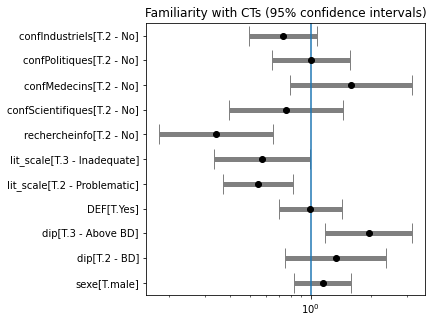

In [136]:
regression1 = pyshs.regression_logistique(data,"ConnaissanceBien",var_ind,"weight",table_only=False)

# Mise en forme
u1 = regression1.summary2()
u1 = np.exp(u1.tables[1][["Coef.","[0.025","0.975]"]])
u1["low"] = u1["Coef."]-u1["[0.025"]
u1["up"] = u1["0.975]"]-u1["Coef."]
u1 = u1.drop("Intercept")

# Création d'une figure
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax.errorbar(u1["Coef."],u1.index, xerr=u1[["low","up"]].values.T,fmt='o', color='black',
             ecolor='gray', elinewidth=5, capsize=10)

ax.axvline(1)
ax.set_title("Familiarity with CTs (95% confidence intervals)")
ax.set_xscale('log')

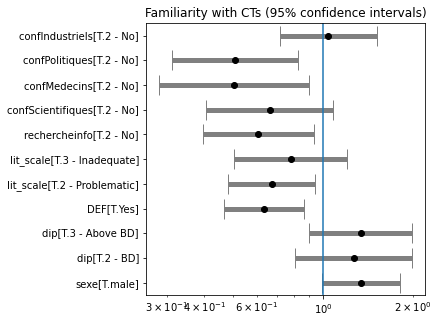

In [138]:
regression2 = pyshs.regression_logistique(data2,"FavorableEC",var_ind,"weight",table_only=False)

# Mise en forme
u2 = regression2.summary2()
u2 = np.exp(u2.tables[1][["Coef.","[0.025","0.975]"]])
u2["low"] = u2["Coef."]-u2["[0.025"]
u2["up"] = u2["0.975]"]-u2["Coef."]
u2 = u2.drop("Intercept")

# Création d'une figure
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax.errorbar(u2["Coef."],u2.index, xerr=u2[["low","up"]].values.T,fmt='o', color='black',
             ecolor='gray', elinewidth=5, capsize=10)

ax.axvline(1)
ax.set_title("Familiarity with CTs (95% confidence intervals)")
ax.set_xscale('log')